# CLASSICAL MODELING
BY : **AUDREY EMERIBE**

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Necessary libraries for plotting
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Boosting model
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# To build a pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

import time

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

# Metrics (Computation)
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Model interpretation
import shap

# To "pickle" things, like accuracies or even an entire fitted model
import joblib
import pickle

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Read in the file to be used
df = pd.read_csv("Toddler Autism dataset July 2018.csv")

# Looking at the first five rows of the dataset
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


## BASIC EDA

In [12]:
# Check the distribution of target variable
df["Class/ASD Traits "].value_counts()

Yes    728
No     326
Name: Class/ASD Traits , dtype: int64

- The target variable is "Class/ASD Traits ". It contains 2 values - 0 and 1.

- 0 is for No ASD trait prediction and 1 for presence of ASD Trait .

- Problem is binary classification task

In [13]:
# Dropping columns that aren't useful
df = df.drop(columns=['Case_No','Qchat-10-Score','Who completed the test', 'Ethnicity'])

#  check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   A1                   1054 non-null   int64 
 1   A2                   1054 non-null   int64 
 2   A3                   1054 non-null   int64 
 3   A4                   1054 non-null   int64 
 4   A5                   1054 non-null   int64 
 5   A6                   1054 non-null   int64 
 6   A7                   1054 non-null   int64 
 7   A8                   1054 non-null   int64 
 8   A9                   1054 non-null   int64 
 9   A10                  1054 non-null   int64 
 10  Age_Mons             1054 non-null   int64 
 11  Sex                  1054 non-null   object
 12  Jaundice             1054 non-null   object
 13  Family_mem_with_ASD  1054 non-null   object
 14  Class/ASD Traits     1054 non-null   object
dtypes: int64(11), object(4)
memory usage: 123.6+ KB


In [14]:
df['Jaundice'] = np.where(df['Jaundice'] == 'yes', 1, 0)
df['Jaundice'].value_counts()

0    766
1    288
Name: Jaundice, dtype: int64

In [15]:
df['Family_mem_with_ASD'] = np.where(df['Family_mem_with_ASD'] == 'yes', 1, 0)
df['Family_mem_with_ASD'].value_counts()

0    884
1    170
Name: Family_mem_with_ASD, dtype: int64

In [16]:
df['Class/ASD Traits '] = np.where(df['Class/ASD Traits '] == 'Yes', 1, 0)
df['Class/ASD Traits '].value_counts()

1    728
0    326
Name: Class/ASD Traits , dtype: int64

In [17]:
df['Sex'] = df['Sex'].map({'m': 1, 'f': 0})
df['Sex'].value_counts()

1    735
0    319
Name: Sex, dtype: int64

In [18]:
# EDA for data checking data shape, missing values and duplicates
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Duplicated rows: {df.duplicated().sum()}")

Rows: 1054
Columns: 15
Missing values: 0
Duplicated rows: 143


## MODEL FITTING

In [19]:
# Define the features(X) and target(y) variables
 
X = df.drop('Class/ASD Traits ', axis=1)

# Set the target
y = df['Class/ASD Traits ']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

### FITTING AN eXTREME GRADIENT BOOSTING(XGBOOST) CLASSIFIER MODEL USING GRID SEARCH
**Methodology:**
- Create a pipeline
- List the hyperparameters for tuning
- Insert hyperparameters into pipeline and do a Grid search for best model
- Fit the best model and check the model scores

In [20]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline

# Create placeholders for XGB step
estimators = [
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
]

pipe = Pipeline(estimators, memory=cachedir)

In [21]:
# Visualize the pipeline
set_config(display="diagram")
pipe  # click on the diagram below to see the details of each step

Pipeline(memory='C:\\Users\\audre\\AppData\\Local\\Temp\\tmpptdijucz',
         steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [22]:
# Define the parameters for the XGB grid search
param_grid = [
    { 
        'scaler': [StandardScaler(), MinMaxScaler(), None],
        'model': [XGBClassifier()], 
        'model__max_depth': [5,7,10],
        'model__learning_rate': [0.01, 0.05, 0.1],  
        'model__n_estimators': [100, 200, 500, 1000],
        'model__colsample_bytree': [0.3, 0.7]
    }
]

XGB_grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

XGB_fittedgrid = XGB_grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [23]:
# Best estimator for XGB model
XGB_fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\audre\\AppData\\Local\\Temp\\tmpptdijucz',
         steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.3, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, ...))])

In [24]:
# Best hyperparameters for XGB model
XGB_fittedgrid.best_params_

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.3, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=1000, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'model__colsample_bytree': 0.3,
 'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__n_estimators': 1000,
 'scaler': StandardScaler()}

In [25]:
# Scale the data
# Instantiate the scaler
ss = StandardScaler()

# Fit (ON THE TRAINING DATA)
ss.fit(X_train)

# Transform (both the train and test data)
X_train_ss = ss.transform(X_train)
X_test_ss= ss.transform(X_test)

In [26]:
# Using the best model parameter
tuned_XGB =  XGBClassifier(colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=1000)

In [27]:
# fitting the XGBoost model
tuned_XGB.fit(X_train_ss,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [28]:
# Model Predictions for train and test set
y_train_pred = tuned_XGB.predict(X_train_ss)
y_pred_XGB = tuned_XGB.predict(X_test_ss)

In [29]:
# The Root Mean Squared Error for test set
print("Root Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_XGB, squared=False))
print(f'Test MAE ---- {mean_absolute_error(y_test, y_pred_XGB)}')
print(f"XGB Train score: {tuned_XGB.score(X_train_ss, y_train)}")
print(f"XGB Test score: {tuned_XGB.score(X_test_ss, y_test)}")

Root Mean squared error: 0.00
Test MAE ---- 0.0
XGB Train score: 1.0
XGB Test score: 1.0


In [30]:
# Training confusion matrix
from sklearn.metrics import confusion_matrix

print("Train:")
print(confusion_matrix(y_train, y_train_pred))

# Test confusion matrix
print("Test:")
print(confusion_matrix(y_test, y_pred_XGB))

Train:
[[244   0]
 [  0 546]]
Test:
[[ 82   0]
 [  0 182]]


In [31]:
confusion_matrix = confusion_matrix(y_test, y_pred_XGB)
# label rows and columns
confusion_df = pd.DataFrame(
    confusion_matrix, 
    columns=["Predicted presence of ASD Trait", "Predicted absence of ASD Trait"],
    index=["True presence of ASD Trait", "True absence of ASD Trait"]
)

display(confusion_df)

,Predicted presence of ASD Trait,Predicted absence of ASD Trait
True presence of ASD Trait,82,0
True absence of ASD Trait,0,182


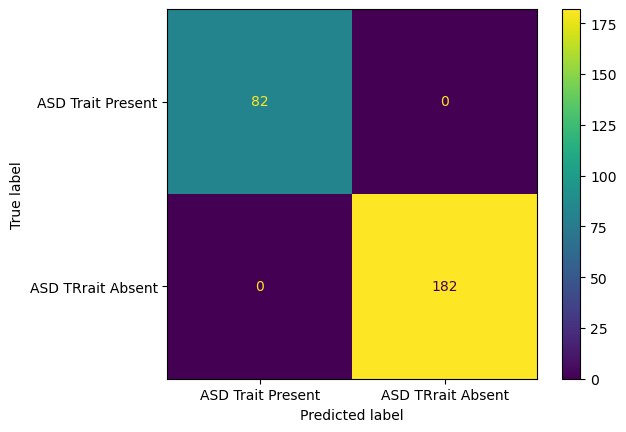

In [32]:
# using confusion_matrix_display - set display_labels parameter for class names
plot_confusion_matrix(tuned_XGB, X_test_ss, y_test, display_labels=["ASD Trait Present", "ASD TRrait Absent"])
plt.show()

In [33]:
# Checking the classification report for XGBoost
print(classification_report(y_test, y_pred_XGB, target_names=["ASD Trait Present", "ASD TRrait Absent"]))

                   precision    recall  f1-score   support

ASD Trait Present       1.00      1.00      1.00        82
ASD TRrait Absent       1.00      1.00      1.00       182

         accuracy                           1.00       264
        macro avg       1.00      1.00      1.00       264
     weighted avg       1.00      1.00      1.00       264



### FITTING AN CATEGORICAL BOOSTING(CATBOOST) CLASSIFIER MODEL USING GRID SEARCH

In [34]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline

# Create placeholders for CatBoost step
estimators = [
    ('scaler', StandardScaler()),
    ('model', CatBoostClassifier())
]

pipe = Pipeline(estimators, memory=cachedir)

In [35]:
# Visualize the pipeline
set_config(display="diagram")
pipe  # click on the diagram below to see the details of each step

Pipeline(memory='C:\\Users\\audre\\AppData\\Local\\Temp\\tmpjqlrhy9h',
         steps=[('scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000002859F63B0D0>)])

In [36]:
# Define the parameters for the CatBoost grid search
param_grid = [
    {
          'scaler': [StandardScaler(), MinMaxScaler(), None],
          'model': [CatBoostClassifier()],
          'model__iterations': [500],
          'model__depth': [4, 5, 6, 10],
          'model__loss_function': ['Logloss', 'CrossEntropy'],
          'model__l2_leaf_reg': np.logspace(-20, 1, 3, 5, 7),
          'model__leaf_estimation_iterations': [10],
          'model__logging_level':['Silent'],
          'model__random_seed': [42]
         }
]

Cat_grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
Cat_fittedgrid = Cat_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [37]:
# Best estimator for XGB model
Cat_fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\audre\\AppData\\Local\\Temp\\tmpjqlrhy9h',
         steps=[('scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000002859FBCE910>)])

In [38]:
# Best hyperparameters for CatBoost model
best_param = Cat_fittedgrid.best_params_
best_param

{'model': <catboost.core.CatBoostClassifier at 0x2859f5e24f0>,
 'model__depth': 4,
 'model__iterations': 500,
 'model__l2_leaf_reg': 7.0,
 'model__leaf_estimation_iterations': 10,
 'model__logging_level': 'Silent',
 'model__loss_function': 'Logloss',
 'model__random_seed': 42,
 'scaler': StandardScaler()}

In [39]:
# Using the best model parameter
tuned_CBC =  CatBoostClassifier(iterations=500,
                                loss_function=best_param['model__loss_function'],
                                depth=best_param['model__depth'],
                                l2_leaf_reg=best_param['model__l2_leaf_reg'],
                                leaf_estimation_iterations=10,
                                logging_level='Silent',
                                random_seed=42,
                                train_dir='logloss')

In [40]:
# fitting the XGBoost model
tuned_CBC.fit(X_train_ss,y_train)

In [41]:
# Model Predictions for train and test set
y_CBC_pred = tuned_CBC.predict(X_train_ss)
y_pred_CBC = tuned_CBC.predict(X_test_ss)

In [42]:
# The Root Mean Squared Error for test set
print("Root Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_CBC, squared=False))
print(f'Test MAE ---- {mean_absolute_error(y_test, y_pred_CBC)}')
print(f"CBC Train score: {tuned_CBC.score(X_train_ss, y_train)}")
print(f"CBC Test score: {tuned_CBC.score(X_test_ss, y_test)}")

Root Mean squared error: 0.06
Test MAE ---- 0.003787878787878788
CBC Train score: 1.0
CBC Test score: 0.9962121212121212


In [43]:
# Training confusion matrix
from sklearn.metrics import confusion_matrix

print("Train:")
print(confusion_matrix(y_train, y_CBC_pred))

# Test confusion matrix
print("Test:")
print(confusion_matrix(y_test, y_pred_CBC))

Train:
[[244   0]
 [  0 546]]
Test:
[[ 82   0]
 [  1 181]]


In [44]:
confusion_matrix = confusion_matrix(y_test, y_pred_CBC)
# label rows and columns
confusion_df = pd.DataFrame(
    confusion_matrix, 
    columns=["Predicted presence of ASD Trait", "Predicted absence of ASD Trait"],
    index=["True presence of ASD Trait", "True absence of ASD Trait"]
)

display(confusion_df)

,Predicted presence of ASD Trait,Predicted absence of ASD Trait
True presence of ASD Trait,82,0
True absence of ASD Trait,1,181


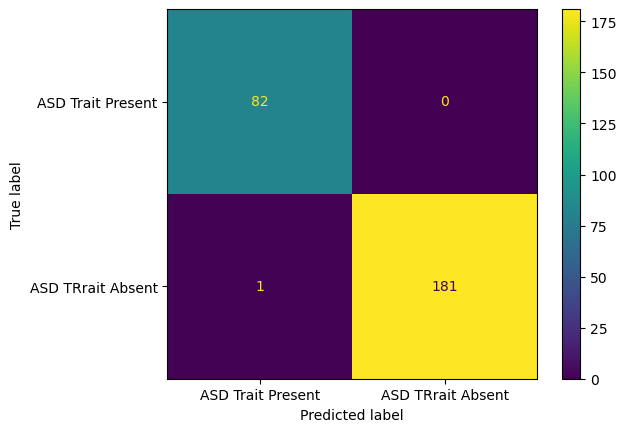

In [45]:
# using confusion_matrix_display - set display_labels parameter for class names
plot_confusion_matrix(tuned_CBC, X_test_ss, y_test, display_labels=["ASD Trait Present", "ASD TRrait Absent"])
plt.show()

In [46]:
# Checking the classification report for CatBoost
print(classification_report(y_test, y_pred_CBC, target_names=["ASD Trait Present", "ASD TRrait Absent"]))

                   precision    recall  f1-score   support

ASD Trait Present       0.99      1.00      0.99        82
ASD TRrait Absent       1.00      0.99      1.00       182

         accuracy                           1.00       264
        macro avg       0.99      1.00      1.00       264
     weighted avg       1.00      1.00      1.00       264



### FITTING AN LIGHT GRADIENT BOOSTING(LGBM) CLASSIFIER MODEL USING GRID SEARCH

In [47]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline

# Create placeholders for CatBoost step
estimators = [
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier())
]

pipe = Pipeline(estimators, memory=cachedir)

In [48]:
# Visualize the pipeline
set_config(display="diagram")
pipe  # click on the diagram below to see the details of each step

Pipeline(memory='C:\\Users\\audre\\AppData\\Local\\Temp\\tmp8se5d8xc',
         steps=[('scaler', StandardScaler()), ('model', LGBMClassifier())])

In [49]:
# Define the parameters for the CatBoost grid search
param_grid = [
    {
     'scaler': [StandardScaler(), MinMaxScaler(), None],
     'model': [LGBMClassifier()],
     'model__num_leaves':[20,40,60,80,100],
     'model__min_child_samples':[5,10,15],
     'model__max_depth':[-1,5,10,20],
     'model__learning_rate':[0.05,0.1,0.2],
     'model__reg_alpha':[0,0.01,0.03]
    }
]
LGBM_grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
LGBM_fittedgrid = LGBM_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


In [50]:
# Best estimator for LGBM model
LGBM_fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\audre\\AppData\\Local\\Temp\\tmp8se5d8xc',
         steps=[('scaler', MinMaxScaler()),
                ('model',
                 LGBMClassifier(learning_rate=0.2, max_depth=5,
                                min_child_samples=15, num_leaves=40,
                                reg_alpha=0.03))])

In [51]:
# Best hyperparameters for LGBM model
LGBM_fittedgrid.best_params_


{'model': LGBMClassifier(learning_rate=0.2, max_depth=5, min_child_samples=15,
                num_leaves=40, reg_alpha=0.03),
 'model__learning_rate': 0.2,
 'model__max_depth': 5,
 'model__min_child_samples': 15,
 'model__num_leaves': 40,
 'model__reg_alpha': 0.03,
 'scaler': MinMaxScaler()}

In [52]:
# Scale the data
# Instantiate the scaler
mm = MinMaxScaler()

# Fit (ON THE TRAINING DATA)
mm.fit(X_train)

# Transform (both the train and test data)
X_train_mm = mm.transform(X_train)
X_test_mm = mm.transform(X_test)

In [53]:
# Using the best model parameter
tuned_LGBM = LGBMClassifier(max_depth=5, min_child_samples=15, num_leaves=20, reg_alpha=0.03)

In [54]:
# fitting the LGBM model
tuned_LGBM.fit(X_train_mm,y_train)

LGBMClassifier(max_depth=5, min_child_samples=15, num_leaves=20, reg_alpha=0.03)

In [55]:
# Model Predictions for train and test set
y_LGBM_pred = tuned_LGBM.predict(X_train_mm)
y_pred_LGBM = tuned_LGBM.predict(X_test_mm)

In [56]:
# The Root Mean Squared Error for test set
print("Root Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_LGBM, squared=False))
print(f'Test MAE ---- {mean_absolute_error(y_test, y_pred_LGBM)}')
print(f"XGB Train score: {tuned_LGBM.score(X_train_mm, y_train)}")
print(f"XGB Test score: {tuned_LGBM.score(X_test_mm, y_test)}")

Root Mean squared error: 0.19
Test MAE ---- 0.03787878787878788
XGB Train score: 1.0
XGB Test score: 0.9621212121212122


In [57]:
# Training confusion matrix
from sklearn.metrics import confusion_matrix

print("Train:")
print(confusion_matrix(y_train, y_LGBM_pred))

# Test confusion matrix
print("Test:")
print(confusion_matrix(y_test, y_pred_LGBM))

Train:
[[244   0]
 [  0 546]]
Test:
[[ 76   6]
 [  4 178]]


In [58]:
confusion_matrix = confusion_matrix(y_test, y_pred_LGBM)
# label rows and columns
confusion_df = pd.DataFrame(
    confusion_matrix, 
    columns=["Predicted presence of ASD Trait", "Predicted absence of ASD Trait"],
    index=["True presence of ASD Trait", "True absence of ASD Trait"]
)

display(confusion_df)

,Predicted presence of ASD Trait,Predicted absence of ASD Trait
True presence of ASD Trait,76,6
True absence of ASD Trait,4,178


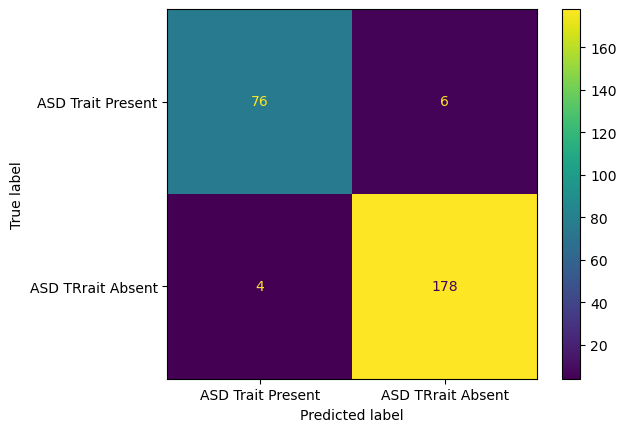

In [59]:
# using confusion_matrix_display - set display_labels parameter for class names
plot_confusion_matrix(tuned_LGBM, X_test_mm, y_test, display_labels=["ASD Trait Present", "ASD TRrait Absent"])
plt.show()

In [60]:
# Checking the classification report for CatBoost
print(classification_report(y_test, y_pred_LGBM, target_names=["ASD Trait Present", "ASD TRrait Absent"]))

                   precision    recall  f1-score   support

ASD Trait Present       0.95      0.93      0.94        82
ASD TRrait Absent       0.97      0.98      0.97       182

         accuracy                           0.96       264
        macro avg       0.96      0.95      0.96       264
     weighted avg       0.96      0.96      0.96       264



## MODEL EVALUATION:

 ### USING TIME
- Evaluating Computation time

In [61]:
%%timeit
tuned_XGB.fit(X_train_ss, y_train)
tuned_XGB.predict(X_test_ss)

1.37 s ± 55.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%%timeit
tuned_CBC.fit(X_train_ss, y_train)
tuned_CBC.predict(X_test_ss)

1.34 s ± 94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%%timeit
tuned_LGBM.fit(X_train_mm, y_train)
tuned_LGBM.predict(X_test_mm)

273 ms ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### USING ACCURACY SCORE

In [64]:
tuned_XGB.fit(X_train_ss, y_train)
tuned_CBC.fit(X_train_ss, y_train)
tuned_LGBM.fit(X_train_mm, y_train)

print("Test Set Scores:")
print(f"XGBoost score: {tuned_XGB.score(X_test_ss, y_test)}")
print(f"CatBoost score: {tuned_CBC.score(X_test_ss, y_test)}")
print(f"LGBM score: {tuned_LGBM.score(X_test_mm, y_test)}")

Test Set Scores:
XGBoost score: 1.0
CatBoost score: 0.9962121212121212
LGBM score: 0.9621212121212122


**BEST MODEL CHOICE:**
- With respect to both F1 Score and Computational Time, **XGBoost model** seems the best model choice

In [65]:
# use joblib to pickle the best model for future use
joblib.dump(XGB_fittedgrid.best_estimator_, 'pickle_best_XGB.pkl')

['pickle_best_XGB.pkl']

In [66]:
# Sanity check on the pickled model
pickled_best_XGB = joblib.load('pickle_best_XGB.pkl')

# Print the accuracies
print(f"The best XGB accuracy on the train set: {pickled_best_XGB.score(X_train_ss, y_train)}")
print(f"The best XGB accuracy on the test set: {pickled_best_XGB.score(X_test_ss, y_test)}")

The best XGB accuracy on the train set: 1.0
The best XGB accuracy on the test set: 1.0


## MODEL INTERPRETATION USING SHAP VALUES
In order to interpret model predictions, we would use a model-agnostic method. This method, instead of describing the average behaviour of a machine learning model, will try to explain individual predictions. The model being used is SHapley Additive ExPlanations, or SHAP.

**SHAP** uses Shapley values to explain individual predictions

- Shapley value is the average marginal contribution of a feature value across all possible coalition. The Shapley value is the feature contribution to the prediction of the target variable

In [67]:
%%time 
# Interprete using Shapley values

# Fit tree-specific kernel for SHAP  
explainer = shap.TreeExplainer(tuned_XGB)

# Obtain SHAP values 
shap_values = explainer.shap_values(X_train_ss)

Wall time: 1.21 s


In [68]:
# Initiate Javascript for visualization 
shap.initjs()

# Plot SHAP values for row 0 
shap.force_plot(explainer.expected_value,       # Plots the average prediction on the plot
                shap_values[0],                 # Plots the Shapley values on the force plot 
                features=X_train.iloc[0],       # 'features' displays the value that is passed to it on the plot; feature value plotted for easier interpretation
                feature_names=X_train.columns)  # 'feature_names' displays the name of the features

**Observation:**

- Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue
- All the Q-chart-score positive answers all push  for a higher prediction of ASD Traits
- This shows that the child has ASD traits

In [69]:
# Initiate Javascript for visualization 
shap.initjs()

# Plot SHAP values for row 40 
shap.force_plot(explainer.expected_value,       # Plots the average prediction on the plot
                shap_values[40],                 # Plots the Shapley values on the force plot 
                features=X_train.iloc[40],       # 'features' displays the value that is passed to it on the plot; feature value plotted for easier interpretation
                feature_names=X_train.columns)  # 'feature_names' displays the name of the features

**Observation:**
- With most of the A-feature values as 0, this pushes the ASD trait prediction to  be low
- It can be deduced that this patient do not have ASD traits and is predicted as no ASD Trait present

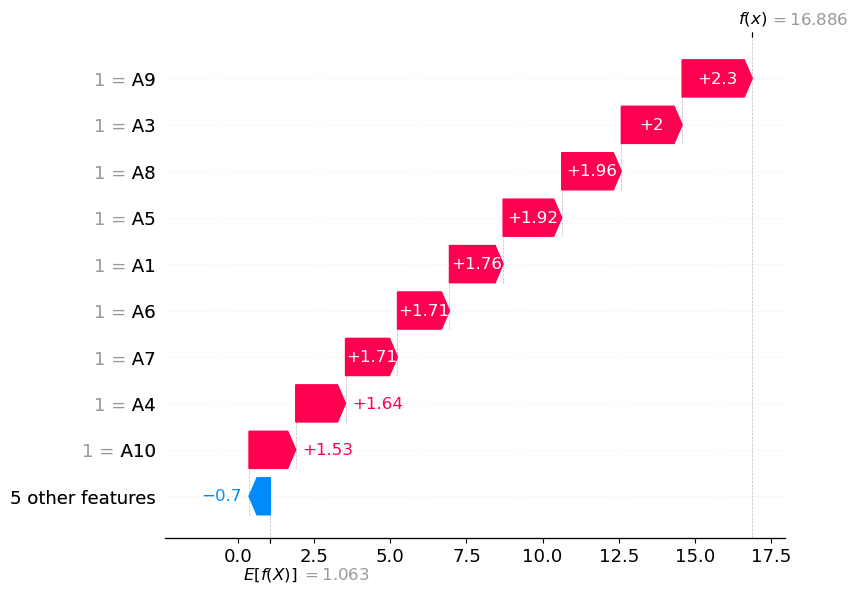

In [70]:
shap.waterfall_plot(shap.Explanation(values = shap_values[0], 
                                     base_values = explainer.expected_value, 
                                     data = X_train.iloc[0],  
                                     feature_names = X_train.columns.tolist()))

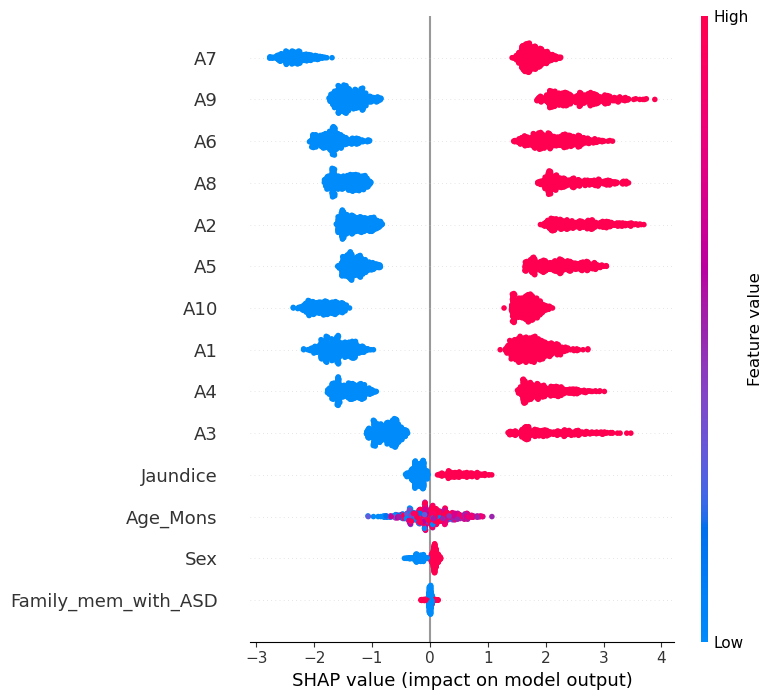

In [71]:
# Global interpretation - summary plot - type = 'dot'
shap.initjs()

shap.summary_plot(shap_values, features=X_train_ss, feature_names=X_train.columns)

**Observations:**
- The A1 - A10 variables have a really high positive contribution when the value is 1, and a low negative contribution on 0 values. 


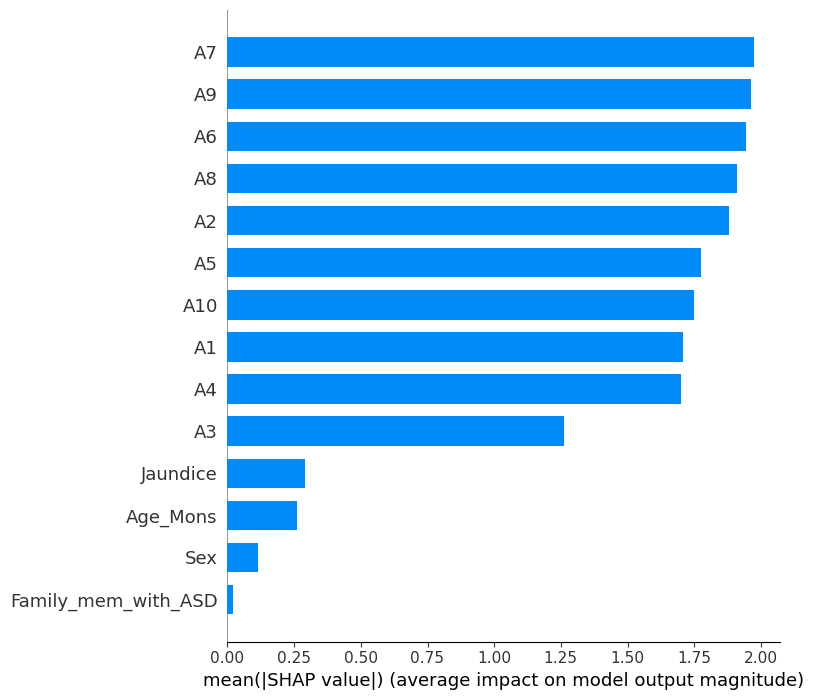

In [72]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

**Observations:**
- We see all Q-chart-score questions as the top 10 important features for the prediction
- This shows the Q-chart method is most effective for ASD trait prediction
- A9, A7, A6, A8, A2 as the top 5 features shows inattentive behavior, delayed cognitive and learning skills, unusual emotional reaction and delayed motion skills 